In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contractions/contractions.csv
/kaggle/input/rilloff/riloff_dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/ghoshdata/sarcasm_dataset.json


In [11]:
# Import Libraries
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
from transformers import RobertaTokenizer, TFAutoModel, TFRobertaModel,AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [3]:
# Setup NLTK components
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Load contractions
contractions = pd.read_csv('/kaggle/input/contractions/contractions.csv', index_col='Contraction', encoding='latin-1')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define regex patterns
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtagPattern = r'#\S+'
sequencePattern = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Text Preprocessing
def preprocess_apply(tweet):
    tweet = tweet.lower()
    tweet = re.sub(urlPattern, '', tweet)
    tweet = re.sub(userPattern, '', tweet)
    tweet = re.sub(hashtagPattern, '', tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)
    return re.sub(r'/', ' / ', tweet).strip()

def preprocess(tweet, stem=True):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = [stemmer.stem(word) if stem else word for word in tweet.split() if word not in stop_words]
    return " ".join(tokens)

# Feature Extraction
def extract_features(text):
    return [
        len(re.findall(r'[\U0001F600-\U0001F64F]', text)),  # Emojis
        len(re.findall(r'[!?.]', text)),                   # Punctuation
        len(re.findall(r'#\S+', text)),                    # Hashtags
        len(re.findall(r'@\S+', text)),                    # User mentions
        sum(1 for c in text if c.isupper()),               # Capital letters
        len(re.findall(r'(.)\1{2,}', text)),               # Elongated words
        len(re.findall(r'\b(very|so|totally|really)\b', text, re.IGNORECASE)),  # Intensifiers
        len(re.findall(r'\b(oh|wow|oops|ugh|eh)\b', text, re.IGNORECASE))       # Interjections
    ]

# Encode Sentences and Features
def encode_inputs(sentences, tokenizer, max_length, use_features=False):
    input_ids = []
    extra_features = []

    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=False
        )
        input_ids.append(encoding['input_ids'])

        if use_features:
            features = extract_features(sentence)
            extra_features.append(features)
            
    return np.array(input_ids), (np.array(extra_features) if use_features else None)

# Build Model
def build_model(pretrained_model_name, feature_size, max_length, dense_units, dropout_rate, learning_rate, use_features=False):
    text_input = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="text_input")
    transformer_model = TFAutoModel.from_pretrained(pretrained_model_name)
    transformer_output = transformer_model(text_input).last_hidden_state[:, 0, :]  # CLS token
    
    if use_features:
        extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")
        combined = tf.keras.layers.Concatenate()([transformer_output, extra_input])
    else:
        combined = transformer_output
    
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    inputs = [text_input] if not use_features else [text_input, extra_input]
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [19]:
def main(dataset_path, pretrained_model_name, use_features=False):
    print(f"Using Dataset: {dataset_path}")
    print(f"Using Pretrained Model: {pretrained_model_name}")
    
    # Load Dataset
    data = pd.read_json(dataset_path, lines=True)
    
    # Extract features BEFORE preprocessing
    if use_features:
        data['features'] = data['headline'].apply(lambda x: extract_features(x))
    
    # Preprocess text
    data['processed_text'] = data['headline'].apply(preprocess_apply).apply(preprocess)

    # Prepare Labels and Sentences
    labels = data['is_sarcastic'].values
    sentences = data['processed_text'].values

    # Split Data
    train_sents, test_sents, train_labels, test_labels, train_indices, test_indices = train_test_split(
        sentences, labels, np.arange(len(sentences)), test_size=0.15, stratify=labels
    )

    # Tokenizer and Model Setup
    MAX_LENGTH = 32
    if pretrained_model_name == "gpt2":
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        tokenizer.pad_token = tokenizer.eos_token  # Set pad_token for GPT-2
    else:
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

    # Encode Inputs
    train_text_ids, _ = encode_inputs(train_sents, tokenizer, MAX_LENGTH, use_features=False)
    test_text_ids, _ = encode_inputs(test_sents, tokenizer, MAX_LENGTH, use_features=False)

    # Encode Features (if applicable)
    if use_features:
        train_features = np.stack(data.iloc[train_indices]['features'])
        test_features = np.stack(data.iloc[test_indices]['features'])
    else:
        train_features, test_features = None, None

    # Determine Feature Size
    feature_size = train_features.shape[1] if use_features else 0

    # Build and Train Model
    model = build_model(pretrained_model_name, feature_size, MAX_LENGTH, dense_units=128, dropout_rate=0.2, learning_rate=1e-5, use_features=use_features)

    print("Training model...")
    if use_features:
        history = model.fit(
            [train_text_ids, train_features], train_labels,
            validation_data=([test_text_ids, test_features], test_labels),
            epochs=3, batch_size=32
        )
    else:
        history = model.fit(
            train_text_ids, train_labels,
            validation_data=(test_text_ids, test_labels),
            epochs=3, batch_size=32
        )

    # Evaluate Model
    print("Evaluating model...")
    if use_features:
        predictions = model.predict([test_text_ids, test_features])
    else:
        predictions = model.predict(test_text_ids)

    predictions = (predictions.flatten() > 0.5).astype(int)

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions, target_names=["Not Sarcastic", "Sarcastic"]))

    # Plot Training Graphs
    def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_' + string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_' + string])
        plt.show()

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
761/761 [==============================] - 188s 173ms/step - loss: 0.6068 - accuracy: 0.6545 - val_loss: 0.4623 - val_accuracy: 0.7831
Epoch 2/3
761/761 [==============================] - 119s 157ms/step - loss: 0.4363 - accuracy: 0.7962 - val_loss: 0.3909 - val_accuracy: 0.8185
Epoch 3/3
761/761 [==============================] - 119s 157ms/step - loss: 0.3636 - accuracy: 0.8355 - val_loss: 0.3820 - val_accuracy: 0.8248
Evaluating model...
135/135 [==============================] - 19s 60ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.81      0.86      0.84      2240
    Sarcastic       0.84      0.78      0.81      2053

     accuracy                           0.82      4293
    macro avg       0.83      0.82      0.82      4293
 weighted avg       0.83      0.82      0.82      4293



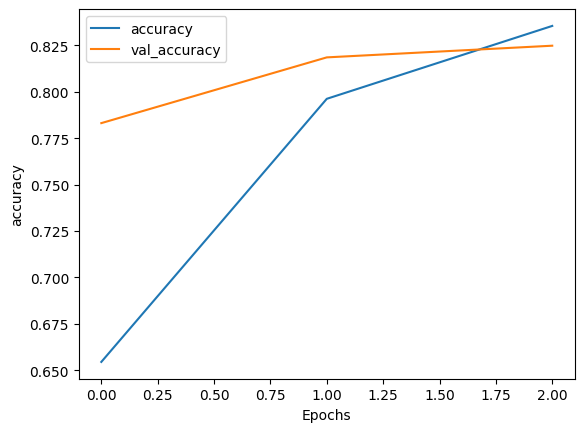

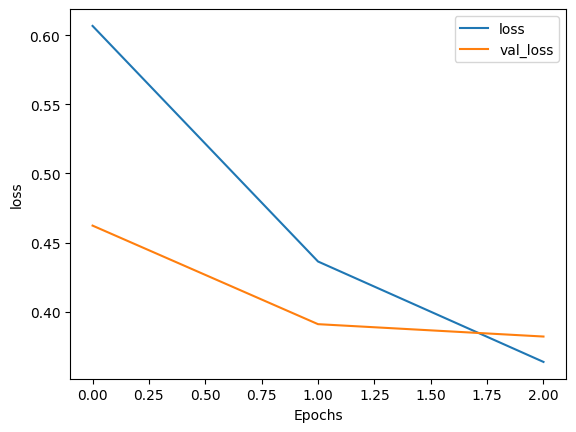

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: vinai/bertweet-base


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 190s 175ms/step - loss: 0.6322 - accuracy: 0.6303 - val_loss: 0.4904 - val_accuracy: 0.7699
Epoch 2/3
761/761 [==============================] - 120s 158ms/step - loss: 0.4789 - accuracy: 0.7728 - val_loss: 0.4215 - val_accuracy: 0.8104
Epoch 3/3
761/761 [==============================] - 120s 158ms/step - loss: 0.4077 - accuracy: 0.8152 - val_loss: 0.4295 - val_accuracy: 0.8092
Evaluating model...
135/135 [==============================] - 18s 60ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      0.78      0.81      2208
    Sarcastic       0.78      0.84      0.81      2085

     accuracy                           0.81      4293
    macro avg       0.81      0.81      0.81      4293
 weighted avg       0.81      0.81      0.81      4293



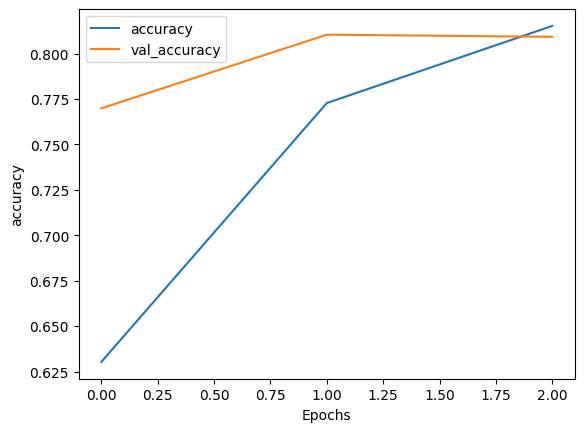

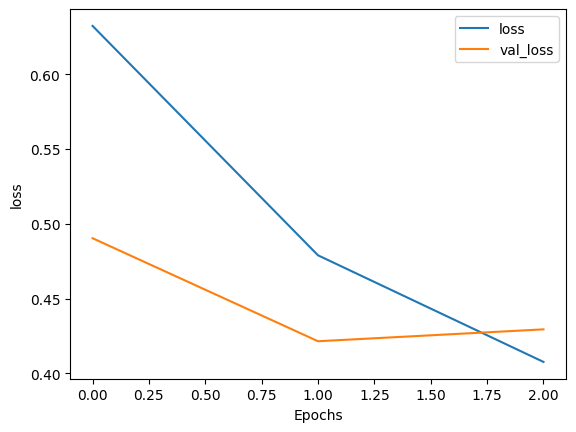

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: xlnet-base-cased


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
761/761 [==============================] - 185s 181ms/step - loss: 0.6782 - accuracy: 0.5859 - val_loss: 0.6371 - val_accuracy: 0.6613
Epoch 2/3
761/761 [==============================] - 129s 170ms/step - loss: 0.5306 - accuracy: 0.7359 - val_loss: 0.4748 - val_accuracy: 0.7666
Epoch 3/3
761/761 [==============================] - 129s 169ms/step - loss: 0.4417 - accuracy: 0.7930 - val_loss: 0.4327 - val_accuracy: 0.7941
Evaluating model...
135/135 [==============================] - 15s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.81      0.78      0.80      2214
    Sarcastic       0.77      0.81      0.79      2079

     accuracy                           0.79      4293
    macro avg       0.79      0.79      0.79      4293
 weighted avg       0.80      0.79      0.79      4293



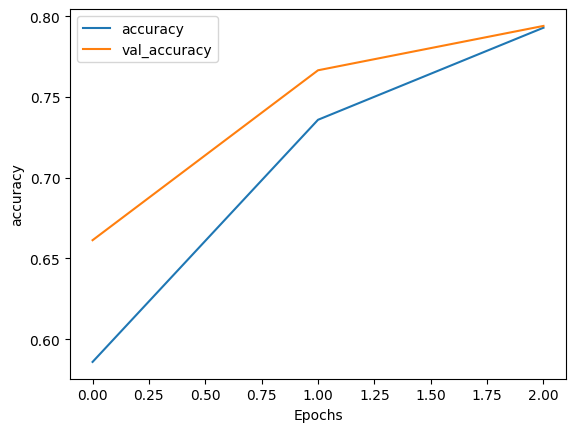

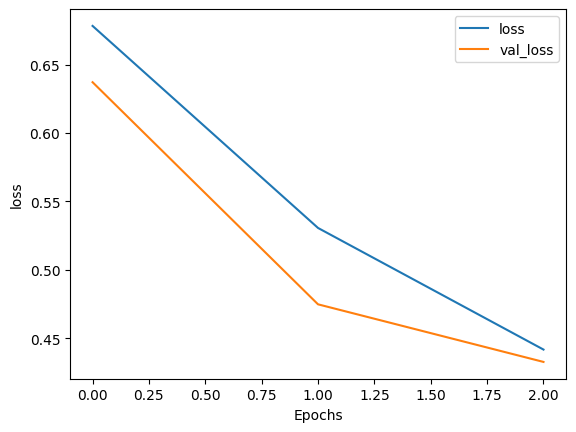

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: gpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [13]:
# Run Experiments
datasets = ["../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",
            "../input/rilloff/riloff_dataset.json"
            "../input/ghoshdata/sarcasm_dataset.json"
           ]
pretrained_models = ['roberta-base', 'vinai/bertweet-base', 'xlnet-base-cased', 'gpt2']

# Without Features
for dataset in datasets:
    for model_name in pretrained_models:
        print("Running without additional features...")
        main(dataset, model_name, use_features=False)

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: gpt2


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 159s 151ms/step - loss: 0.7367 - accuracy: 0.5148 - val_loss: 0.6872 - val_accuracy: 0.5579
Epoch 2/3
761/761 [==============================] - 106s 140ms/step - loss: 0.6720 - accuracy: 0.5751 - val_loss: 0.6594 - val_accuracy: 0.5700
Epoch 3/3
761/761 [==============================] - 106s 140ms/step - loss: 0.6452 - accuracy: 0.6084 - val_loss: 0.6222 - val_accuracy: 0.6334
Evaluating model...
135/135 [==============================] - 13s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.61      0.90      0.72      2296
    Sarcastic       0.73      0.33      0.46      1997

     accuracy                           0.63      4293
    macro avg       0.67      0.61      0.59      4293
 weighted avg       0.67      0.63      0.60      4293



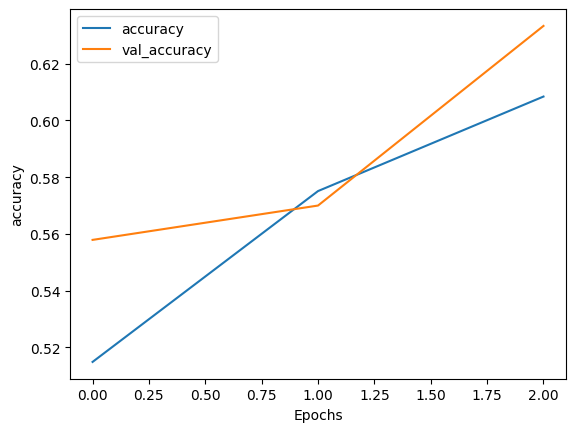

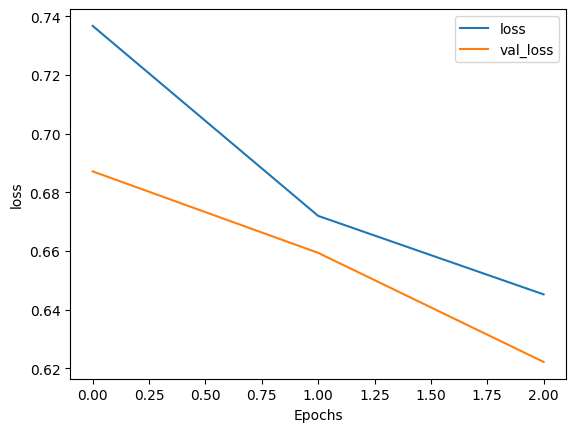

In [15]:
# Run Experiments
datasets = ["../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"]
pretrained_models = ['gpt2']

# Without Features
for dataset in datasets:
    for model_name in pretrained_models:
        print("Running without additional features...")
        main(dataset, model_name, use_features=False)

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
52/52 [==============================] - 79s 389ms/step - loss: 0.5059 - accuracy: 0.8020 - val_loss: 0.4633 - val_accuracy: 0.8163
Epoch 2/3
52/52 [==============================] - 9s 168ms/step - loss: 0.4213 - accuracy: 0.8478 - val_loss: 0.4027 - val_accuracy: 0.8163
Epoch 3/3
52/52 [==============================] - 9s 164ms/step - loss: 0.3208 - accuracy: 0.8616 - val_loss: 0.2446 - val_accuracy: 0.9014
Evaluating model...
10/10 [==============================] - 11s 56ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.96      0.92      0.94       240
    Sarcastic       0.70      0.81      0.75        54

     accuracy                           0.90       294
    macro avg       0.83      0.87      0.85       294
 weighted avg       0.91      0.90      0.90       294



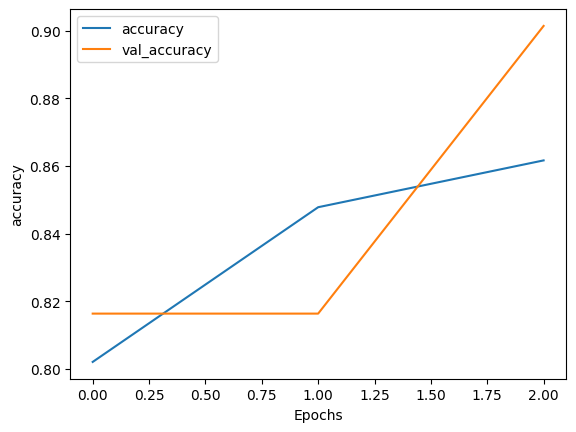

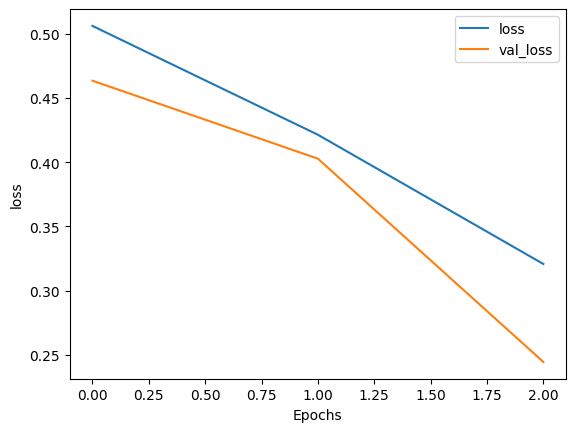

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 79s 387ms/step - loss: 0.4806 - accuracy: 0.7966 - val_loss: 0.5092 - val_accuracy: 0.7959
Epoch 2/3
52/52 [==============================] - 9s 172ms/step - loss: 0.4283 - accuracy: 0.8508 - val_loss: 0.4947 - val_accuracy: 0.7959
Epoch 3/3
52/52 [==============================] - 9s 169ms/step - loss: 0.4181 - accuracy: 0.8508 - val_loss: 0.5195 - val_accuracy: 0.7959
Evaluating model...
10/10 [==============================] - 11s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.80      1.00      0.89       234
    Sarcastic       0.00      0.00      0.00        60

     accuracy                           0.80       294
    macro avg       0.40      0.50      0.44       294
 weighted avg       0.63      0.80      0.71       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


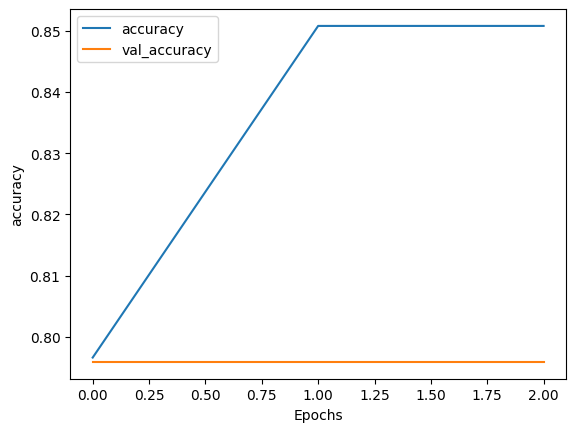

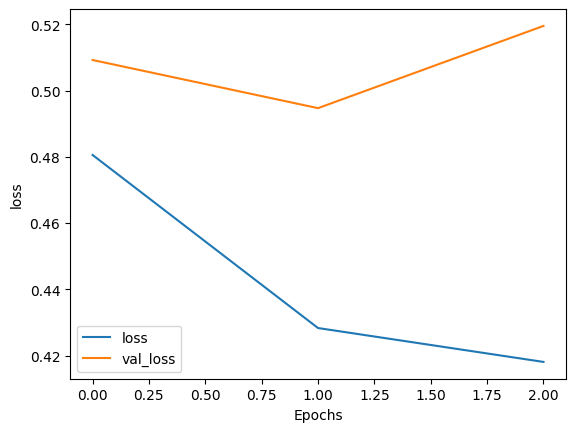

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
52/52 [==============================] - 66s 335ms/step - loss: 0.5338 - accuracy: 0.8147 - val_loss: 0.4155 - val_accuracy: 0.8503
Epoch 2/3
52/52 [==============================] - 10s 184ms/step - loss: 0.4406 - accuracy: 0.8394 - val_loss: 0.3848 - val_accuracy: 0.8503
Epoch 3/3
52/52 [==============================] - 9s 175ms/step - loss: 0.4141 - accuracy: 0.8400 - val_loss: 0.3952 - val_accuracy: 0.8605
Evaluating model...
10/10 [==============================] - 8s 54ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.86      1.00      0.92       250
    Sarcastic       0.80      0.09      0.16        44

     accuracy                           0.86       294
    macro avg       0.83      0.54      0.54       294
 weighted avg       0.85      0.86      0.81       294



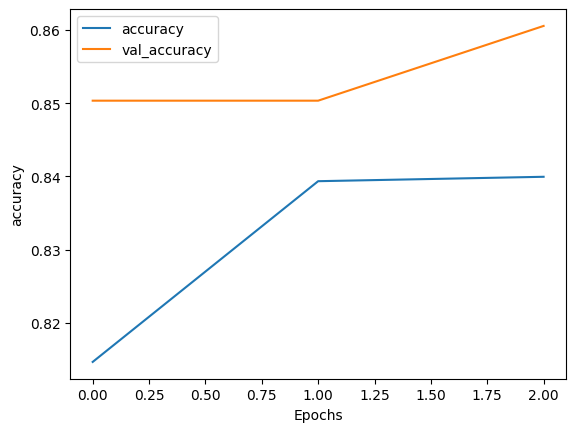

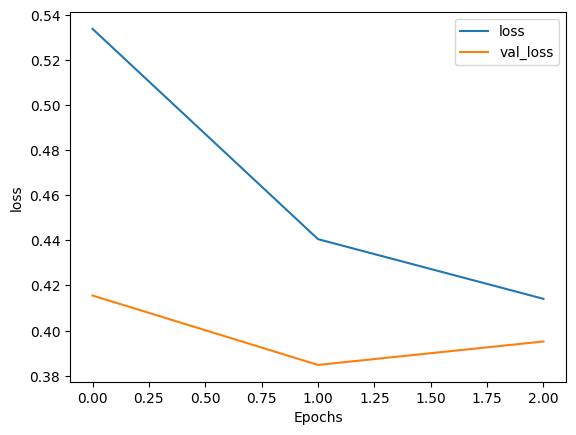

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 61s 309ms/step - loss: 0.8281 - accuracy: 0.7407 - val_loss: 0.4377 - val_accuracy: 0.8333
Epoch 2/3
52/52 [==============================] - 8s 151ms/step - loss: 0.5358 - accuracy: 0.8014 - val_loss: 0.4338 - val_accuracy: 0.8333
Epoch 3/3
52/52 [==============================] - 8s 146ms/step - loss: 0.4927 - accuracy: 0.8273 - val_loss: 0.4306 - val_accuracy: 0.8333
Evaluating model...
10/10 [==============================] - 8s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.83      1.00      0.91       245
    Sarcastic       0.00      0.00      0.00        49

     accuracy                           0.83       294
    macro avg       0.42      0.50      0.45       294
 weighted avg       0.69      0.83      0.76       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


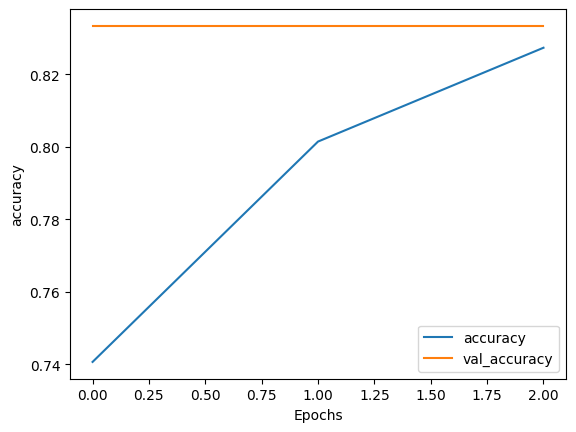

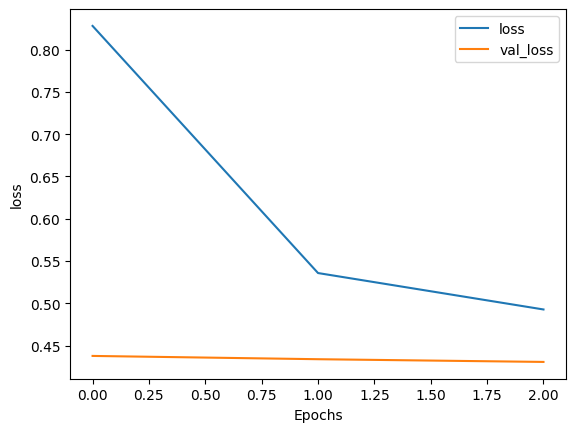

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
1460/1460 [==============================] - 306s 170ms/step - loss: 0.1261 - accuracy: 0.9681 - val_loss: 0.1094 - val_accuracy: 0.9752
Epoch 2/3
1460/1460 [==============================] - 231s 158ms/step - loss: 0.1063 - accuracy: 0.9758 - val_loss: 0.0993 - val_accuracy: 0.9757
Epoch 3/3
1460/1460 [==============================] - 230s 158ms/step - loss: 0.0955 - accuracy: 0.9759 - val_loss: 0.0922 - val_accuracy: 0.9768
Evaluating model...
258/258 [==============================] - 25s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.98      0.98      0.98      4343
    Sarcastic       0.98      0.97      0.98      3897

     accuracy                           0.98      8240
    macro avg       0.98      0.98      0.98      8240
 weighted avg       0.98      0.98      0.98      8240



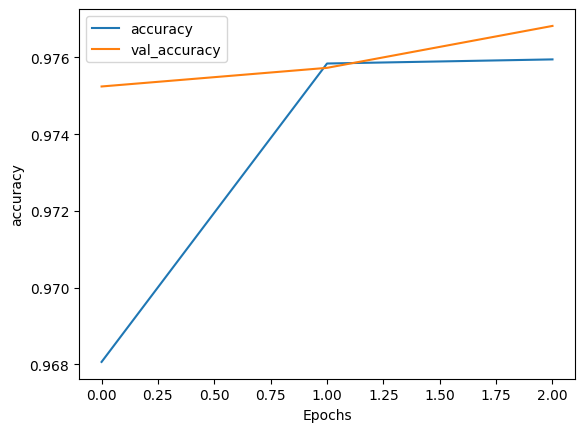

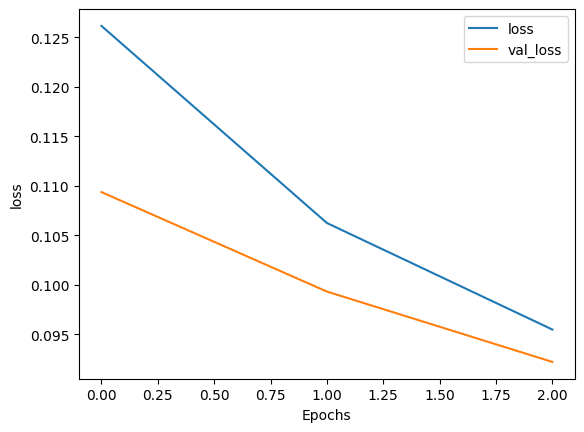

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 309s 169ms/step - loss: 0.2044 - accuracy: 0.9066 - val_loss: 0.1078 - val_accuracy: 0.9768
Epoch 2/3
1460/1460 [==============================] - 231s 159ms/step - loss: 0.1013 - accuracy: 0.9762 - val_loss: 0.0919 - val_accuracy: 0.9766
Epoch 3/3
1460/1460 [==============================] - 232s 159ms/step - loss: 0.0901 - accuracy: 0.9766 - val_loss: 0.0894 - val_accuracy: 0.9774
Evaluating model...
258/258 [==============================] - 26s 60ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.98      0.98      0.98      4374
    Sarcastic       0.98      0.98      0.98      3866

     accuracy                           0.98      8240
    macro avg       0.98      0.98      0.98      8240
 weighted avg       0.98      0.98      0.98      8240



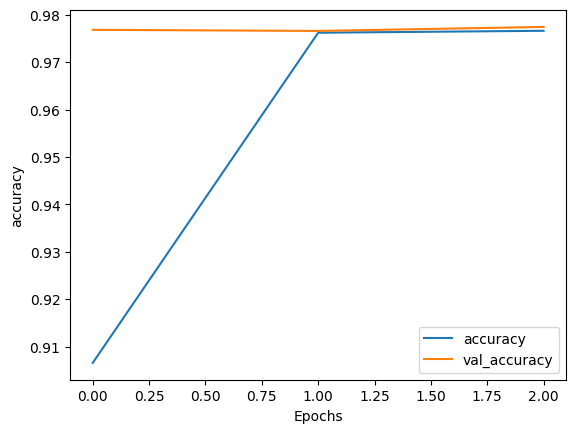

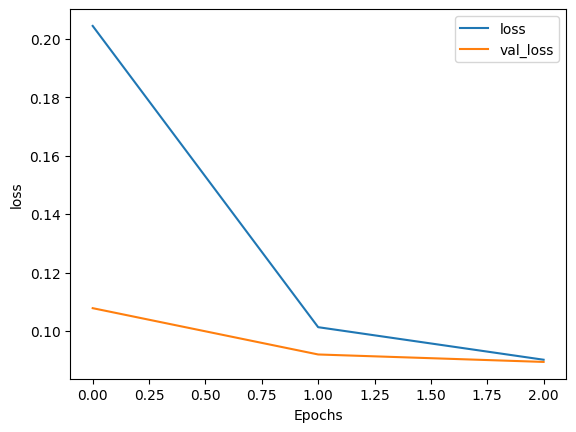

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
1460/1460 [==============================] - 313s 178ms/step - loss: 0.1745 - accuracy: 0.9453 - val_loss: 0.1063 - val_accuracy: 0.9750
Epoch 2/3
1460/1460 [==============================] - 250s 171ms/step - loss: 0.1177 - accuracy: 0.9699 - val_loss: 0.0951 - val_accuracy: 0.9743
Epoch 3/3
1460/1460 [==============================] - 248s 170ms/step - loss: 0.1072 - accuracy: 0.9713 - val_loss: 0.0875 - val_accuracy: 0.9757
Evaluating model...
258/258 [==============================] - 23s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.97      0.98      0.98      4378
    Sarcastic       0.98      0.97      0.97      3862

     accuracy                           0.98      8240
    macro avg       0.98      0.98      0.98      8240
 weighted avg       0.98      0.98      0.98      8240



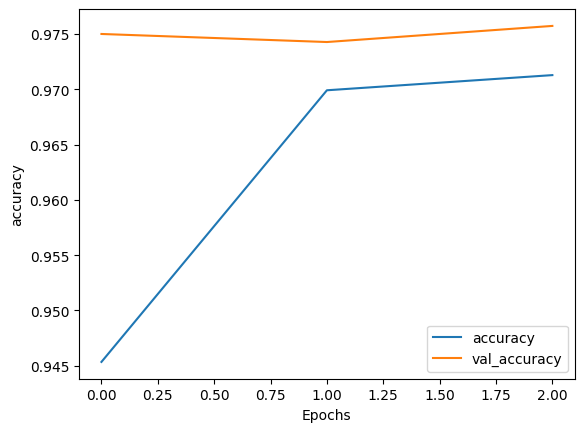

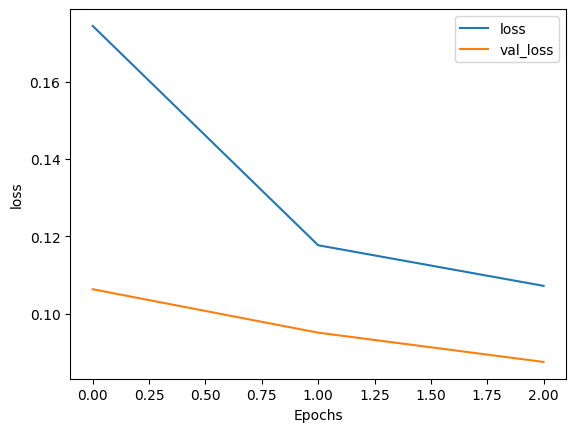

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 260s 147ms/step - loss: 0.7173 - accuracy: 0.5394 - val_loss: 0.6711 - val_accuracy: 0.5388
Epoch 2/3
1460/1460 [==============================] - 204s 140ms/step - loss: 0.6691 - accuracy: 0.5649 - val_loss: 0.6619 - val_accuracy: 0.5784
Epoch 3/3
1460/1460 [==============================] - 204s 140ms/step - loss: 0.6619 - accuracy: 0.5803 - val_loss: 0.6588 - val_accuracy: 0.5825
Evaluating model...
258/258 [==============================] - 19s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.56      0.93      0.70      4326
    Sarcastic       0.73      0.19      0.31      3914

     accuracy                           0.58      8240
    macro avg       0.64      0.56      0.50      8240
 weighted avg       0.64      0.58      0.51      8240



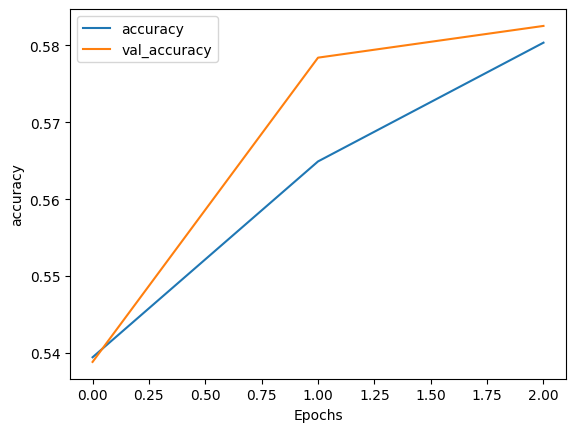

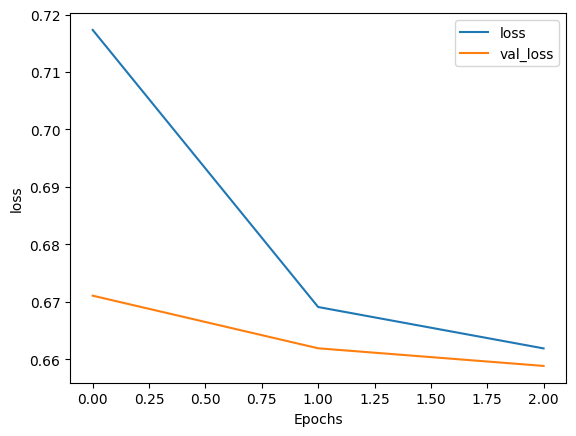

In [18]:
# Run Experiments
datasets = [  "../input/rilloff/riloff_dataset.json",
            "../input/ghoshdata/sarcasm_dataset.json"
           ]
pretrained_models = ['roberta-base', 'vinai/bertweet-base', 'xlnet-base-cased', 'gpt2']

# Without Features
for dataset in datasets:
    for model_name in pretrained_models:
        print("Running without additional features...")
        main(dataset, model_name, use_features=False)

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: roberta-base
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
761/761 [==============================] - 194s 175ms/step - loss: 0.6299 - accuracy: 0.6278 - val_loss: 0.4565 - val_accuracy: 0.7852
Epoch 2/3
761/761 [==============================] - 120s 158ms/step - loss: 0.4343 - accuracy: 0.7956 - val_loss: 0.3945 - val_accuracy: 0.8197
Epoch 3/3
761/761 [==============================] - 120s 158ms/step - loss: 0.3539 - accuracy: 0.8427 - val_loss: 0.4139 - val_accuracy: 0.8134
Evaluating model...
135/135 [==============================] - 18s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.88      0.75      0.81      2248
    Sarcastic       0.76      0.88      0.82      2045

     accuracy                           0.81      4293
    macro avg       0.82      0.82      0.81      4293
 weighted avg       0.82      0.81      0.81      4293



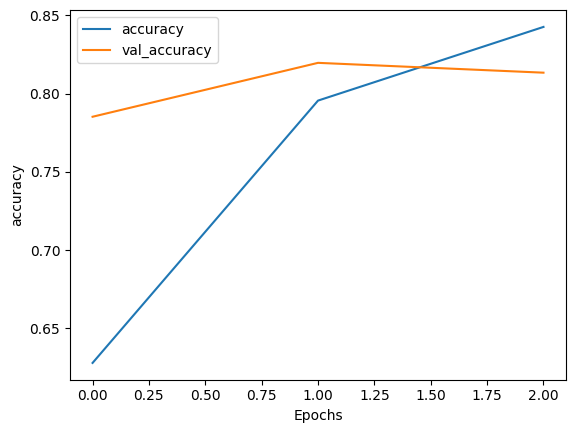

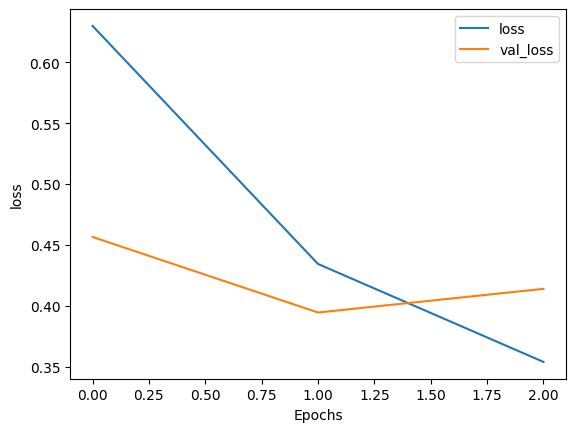

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: vinai/bertweet-base
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 194s 176ms/step - loss: 0.6204 - accuracy: 0.6401 - val_loss: 0.4715 - val_accuracy: 0.7871
Epoch 2/3
761/761 [==============================] - 121s 159ms/step - loss: 0.4460 - accuracy: 0.7987 - val_loss: 0.3853 - val_accuracy: 0.8300
Epoch 3/3
761/761 [==============================] - 121s 159ms/step - loss: 0.3605 - accuracy: 0.8423 - val_loss: 0.3741 - val_accuracy: 0.8328
Evaluating model...
135/135 [==============================] - 18s 60ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.87      0.80      0.83      2248
    Sarcastic       0.80      0.87      0.83      2045

     accuracy                           0.83      4293
    macro avg       0.83      0.83      0.83      4293
 weighted avg       0.84      0.83      0.83      4293



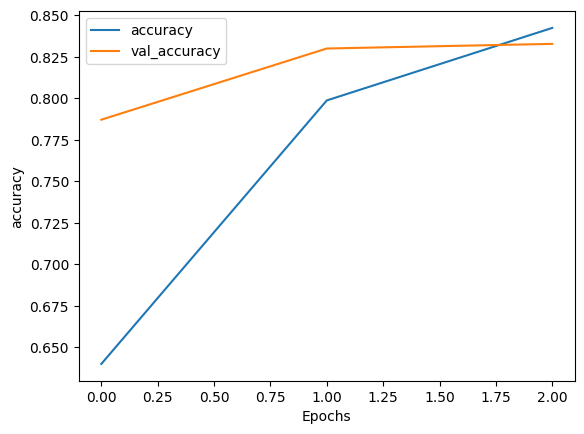

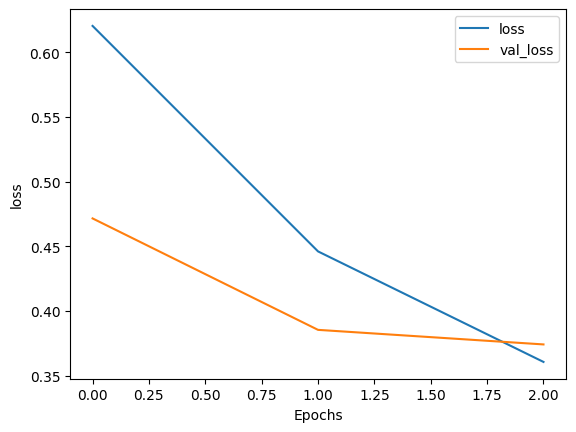

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: xlnet-base-cased
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
761/761 [==============================] - 192s 183ms/step - loss: 0.6998 - accuracy: 0.5491 - val_loss: 0.6285 - val_accuracy: 0.6355
Epoch 2/3
761/761 [==============================] - 130s 171ms/step - loss: 0.5485 - accuracy: 0.7177 - val_loss: 0.5110 - val_accuracy: 0.7482
Epoch 3/3
761/761 [==============================] - 130s 170ms/step - loss: 0.4552 - accuracy: 0.7853 - val_loss: 0.4341 - val_accuracy: 0.7943
Evaluating model...
135/135 [==============================] - 16s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.77      0.86      0.81      2248
    Sarcastic       0.82      0.73      0.77      2045

     accuracy                           0.79      4293
    macro avg       0.80      0.79      0.79      4293
 weighted avg       0.80      0.79      0.79      4293



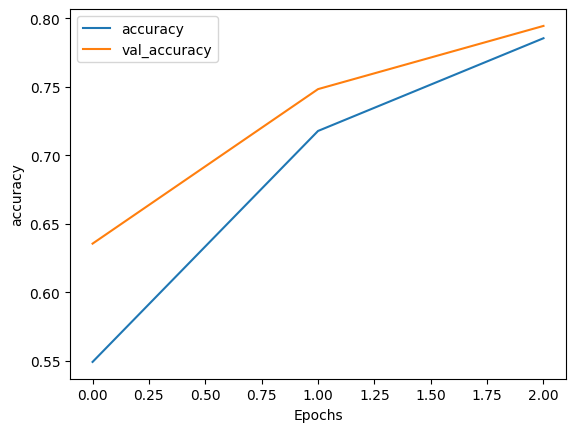

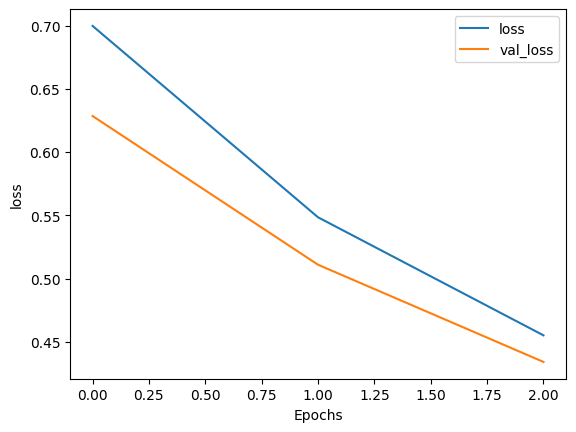

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: gpt2
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 165s 153ms/step - loss: 0.7481 - accuracy: 0.5150 - val_loss: 0.6797 - val_accuracy: 0.5851
Epoch 2/3
761/761 [==============================] - 107s 140ms/step - loss: 0.6760 - accuracy: 0.5681 - val_loss: 0.6562 - val_accuracy: 0.5998
Epoch 3/3
761/761 [==============================] - 107s 140ms/step - loss: 0.6460 - accuracy: 0.6062 - val_loss: 0.6245 - val_accuracy: 0.6322
Evaluating model...
135/135 [==============================] - 13s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.61      0.82      0.70      2248
    Sarcastic       0.69      0.42      0.52      2045

     accuracy                           0.63      4293
    macro avg       0.65      0.62      0.61      4293
 weighted avg       0.65      0.63      0.62      4293



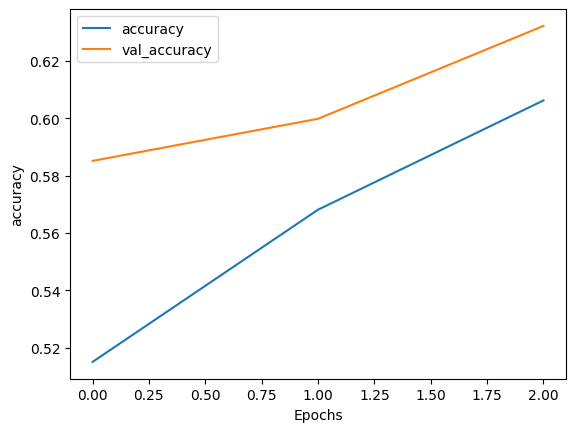

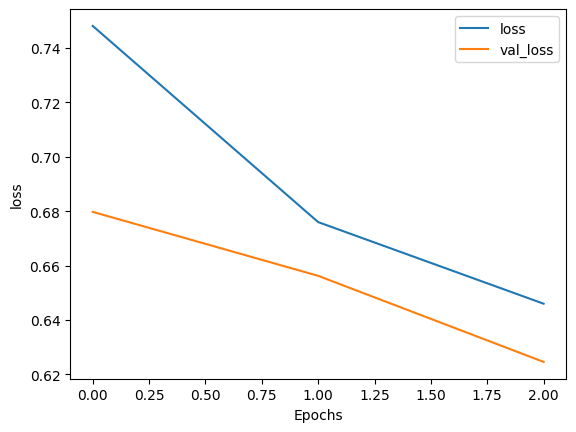

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json../input/ghoshdata/sarcasm_dataset.json | Model: roberta-base
Using Dataset: ../input/rilloff/riloff_dataset.json../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: roberta-base


FileNotFoundError: File ../input/rilloff/riloff_dataset.json../input/ghoshdata/sarcasm_dataset.json does not exist

In [20]:
# Run Experiments
datasets = ["../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",
            "../input/rilloff/riloff_dataset.json"
            "../input/ghoshdata/sarcasm_dataset.json"
           ]
pretrained_models = ['roberta-base', 'vinai/bertweet-base', 'xlnet-base-cased', 'gpt2']

# With Features
for dataset in datasets:
    for model_name in pretrained_models:
        print(f"Running with additional features... | Dataset: {dataset} | Model: {model_name}")
        main(dataset, model_name, use_features=True)

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: roberta-base
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
52/52 [==============================] - 84s 409ms/step - loss: 0.4653 - accuracy: 0.8291 - val_loss: 0.4348 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 9s 170ms/step - loss: 0.4161 - accuracy: 0.8394 - val_loss: 0.3831 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 9s 166ms/step - loss: 0.3386 - accuracy: 0.8556 - val_loss: 0.2878 - val_accuracy: 0.8844
Evaluating model...
10/10 [==============================] - 11s 56ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.90      0.97      0.93       248
    Sarcastic       0.73      0.41      0.53        46

     accuracy                           0.88       294
    macro avg       0.82      0.69      0.73       294
 weighted avg       0.87      0.88      0.87       294



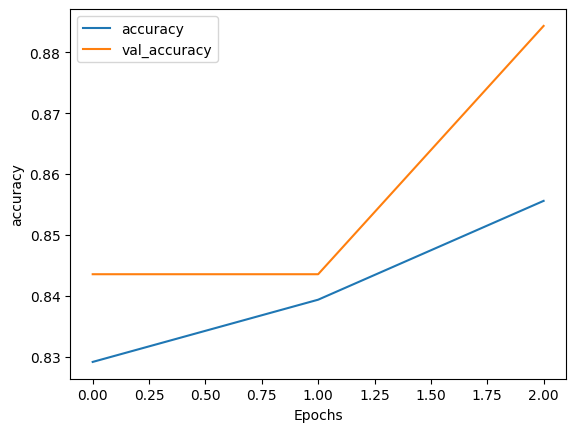

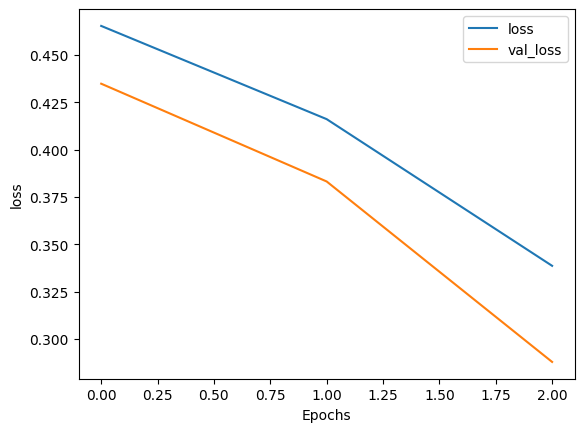

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: vinai/bertweet-base
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 85s 409ms/step - loss: 0.4421 - accuracy: 0.8400 - val_loss: 0.4070 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 9s 165ms/step - loss: 0.4159 - accuracy: 0.8424 - val_loss: 0.4045 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 9s 164ms/step - loss: 0.4151 - accuracy: 0.8424 - val_loss: 0.4018 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 11s 57ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


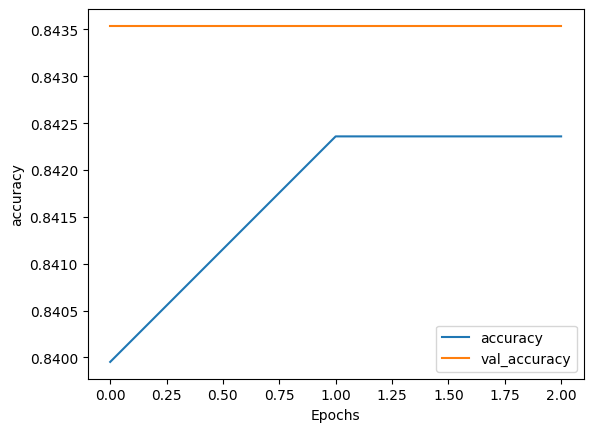

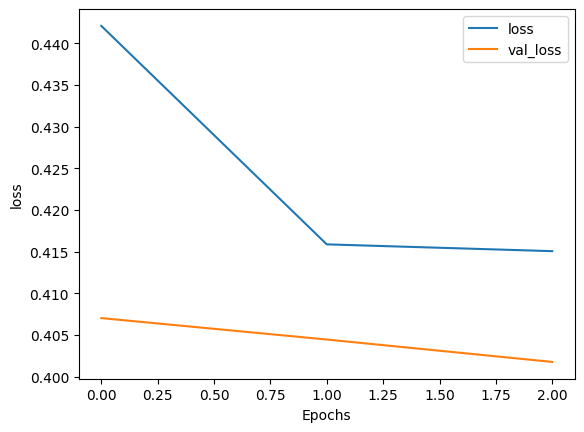

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: xlnet-base-cased
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
52/52 [==============================] - 72s 346ms/step - loss: 0.5808 - accuracy: 0.8111 - val_loss: 0.3970 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 9s 181ms/step - loss: 0.4149 - accuracy: 0.8357 - val_loss: 0.3631 - val_accuracy: 0.8571
Epoch 3/3
52/52 [==============================] - 9s 176ms/step - loss: 0.3732 - accuracy: 0.8514 - val_loss: 0.2859 - val_accuracy: 0.8980
Evaluating model...
10/10 [==============================] - 8s 54ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.90      0.99      0.94       248
    Sarcastic       0.90      0.39      0.55        46

     accuracy                           0.90       294
    macro avg       0.90      0.69      0.74       294
 weighted avg       0.90      0.90      0.88       294



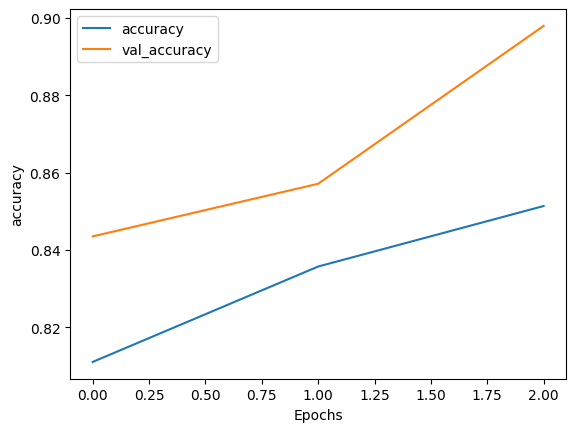

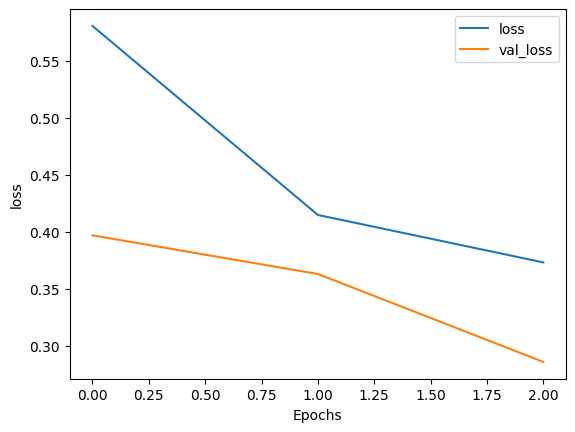

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: gpt2
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 67s 336ms/step - loss: 1.1952 - accuracy: 0.5987 - val_loss: 0.4353 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 8s 146ms/step - loss: 0.5740 - accuracy: 0.7455 - val_loss: 0.4316 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 7s 144ms/step - loss: 0.5481 - accuracy: 0.7726 - val_loss: 0.4251 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 9s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


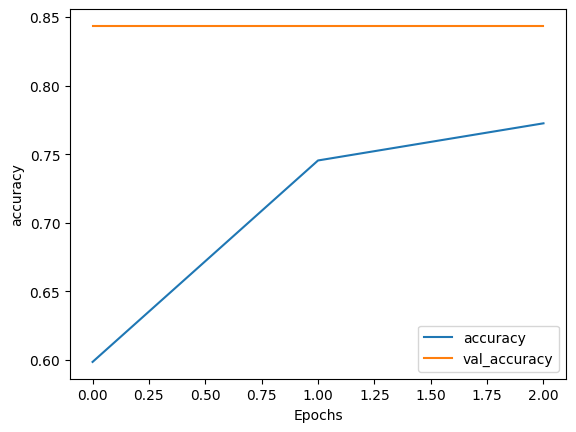

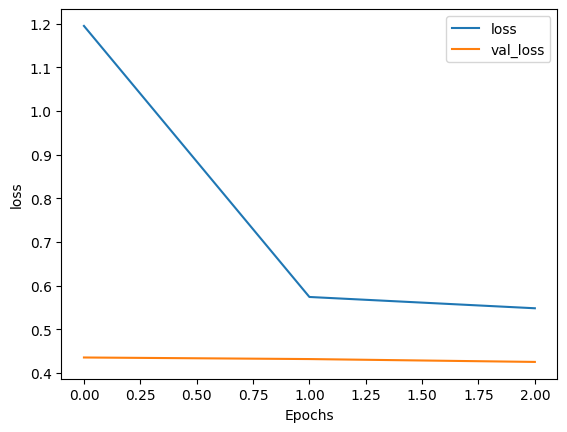

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: roberta-base
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
1460/1460 [==============================] - 307s 168ms/step - loss: 0.5983 - accuracy: 0.6879 - val_loss: 0.5217 - val_accuracy: 0.7467
Epoch 2/3
1460/1460 [==============================] - 231s 158ms/step - loss: 0.4907 - accuracy: 0.7706 - val_loss: 0.4718 - val_accuracy: 0.7788
Epoch 3/3
1460/1460 [==============================] - 231s 158ms/step - loss: 0.4255 - accuracy: 0.8099 - val_loss: 0.4420 - val_accuracy: 0.7931
Evaluating model...
258/258 [==============================] - 26s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.79      0.83      0.81      4359
    Sarcastic       0.80      0.75      0.77      3881

     accuracy                           0.79      8240
    macro avg       0.79      0.79      0.79      8240
 weighted avg       0.79      0.79      0.79      8240



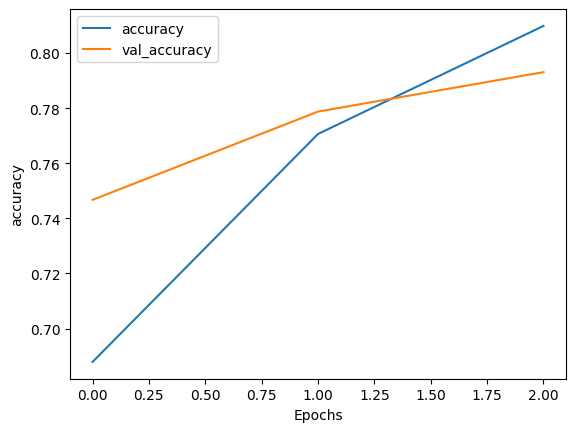

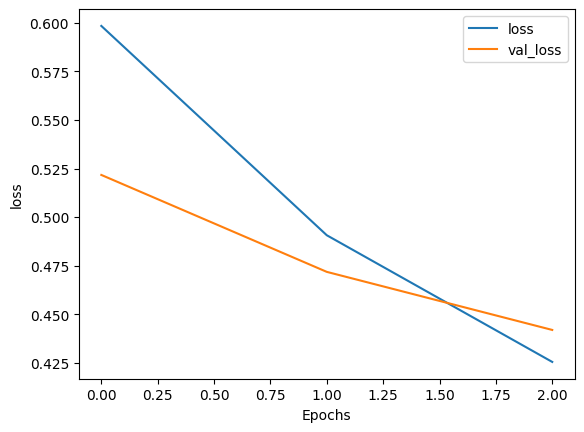

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: vinai/bertweet-base
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 309s 168ms/step - loss: 0.6227 - accuracy: 0.6659 - val_loss: 0.5216 - val_accuracy: 0.7470
Epoch 2/3
1460/1460 [==============================] - 232s 159ms/step - loss: 0.4945 - accuracy: 0.7637 - val_loss: 0.4470 - val_accuracy: 0.7893
Epoch 3/3
1460/1460 [==============================] - 232s 159ms/step - loss: 0.4238 - accuracy: 0.8073 - val_loss: 0.4155 - val_accuracy: 0.8047
Evaluating model...
258/258 [==============================] - 26s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.81      0.82      4359
    Sarcastic       0.79      0.79      0.79      3881

     accuracy                           0.80      8240
    macro avg       0.80      0.80      0.80      8240
 weighted avg       0.80      0.80      0.80      8240



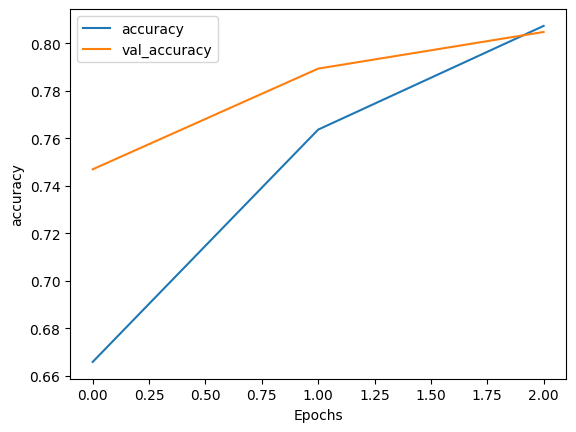

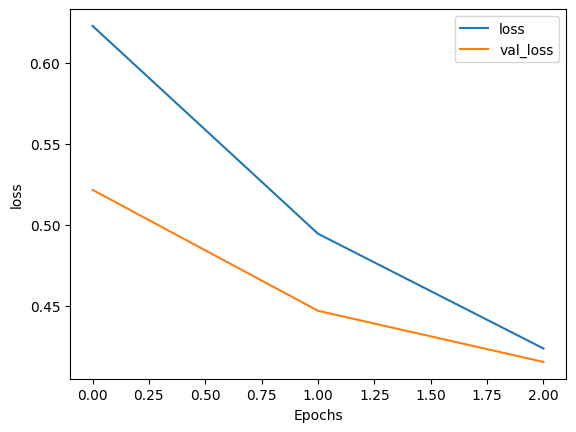

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: xlnet-base-cased
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
1460/1460 [==============================] - 313s 178ms/step - loss: 0.6617 - accuracy: 0.6112 - val_loss: 0.5883 - val_accuracy: 0.6869
Epoch 2/3
1460/1460 [==============================] - 249s 171ms/step - loss: 0.5485 - accuracy: 0.7205 - val_loss: 0.5072 - val_accuracy: 0.7467
Epoch 3/3
1460/1460 [==============================] - 249s 171ms/step - loss: 0.4789 - accuracy: 0.7733 - val_loss: 0.4593 - val_accuracy: 0.7789
Evaluating model...
258/258 [==============================] - 23s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.79      0.80      0.79      4359
    Sarcastic       0.77      0.75      0.76      3881

     accuracy                           0.78      8240
    macro avg       0.78      0.78      0.78      8240
 weighted avg       0.78      0.78      0.78      8240



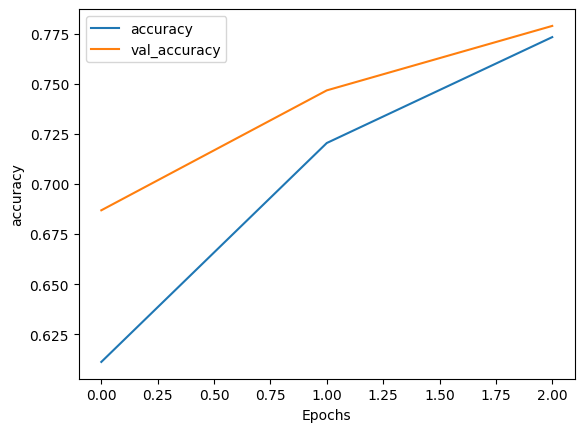

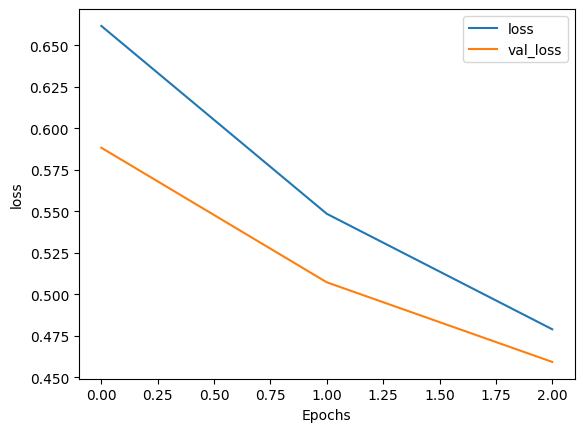

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: gpt2
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 263s 147ms/step - loss: 0.7239 - accuracy: 0.5814 - val_loss: 0.6486 - val_accuracy: 0.6199
Epoch 2/3
1460/1460 [==============================] - 204s 140ms/step - loss: 0.6106 - accuracy: 0.6873 - val_loss: 0.6089 - val_accuracy: 0.6756
Epoch 3/3
1460/1460 [==============================] - 205s 140ms/step - loss: 0.5824 - accuracy: 0.7227 - val_loss: 0.5797 - val_accuracy: 0.6693
Evaluating model...
258/258 [==============================] - 19s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.63      0.91      0.74      4359
    Sarcastic       0.80      0.40      0.53      3881

     accuracy                           0.67      8240
    macro avg       0.71      0.65      0.64      8240
 weighted avg       0.71      0.67      0.64      8240



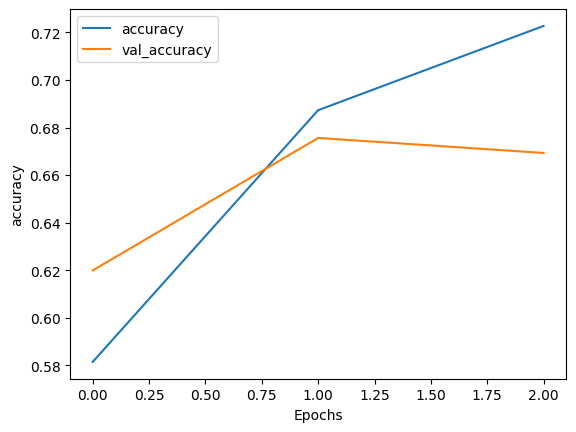

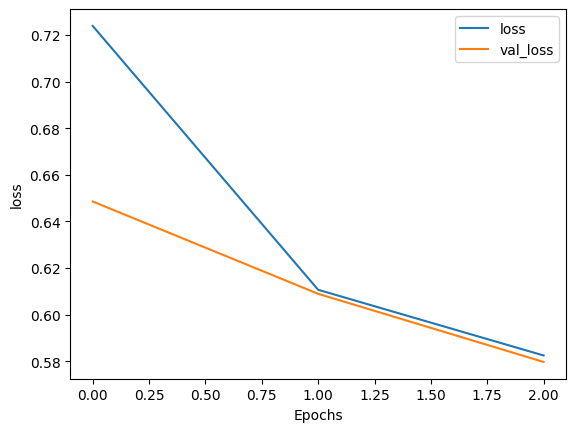

In [21]:
# Run Experiments
datasets = [
            "../input/rilloff/riloff_dataset.json",  "../input/ghoshdata/sarcasm_dataset.json"
           ]
pretrained_models = ['roberta-base', 'vinai/bertweet-base', 'xlnet-base-cased', 'gpt2']

# With Features
for dataset in datasets:
    for model_name in pretrained_models:
        print(f"Running with additional features... | Dataset: {dataset} | Model: {model_name}")
        main(dataset, model_name, use_features=True)